In [1]:
import pandas as pd
import numpy as np
import os
import seaborn
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import altair as alt

## Dataset import/cleaning

In [2]:
pb_only = False # SET TO TRUE TO USE ONLY PERSONAL BEST RECORDS

record_df = pd.DataFrame()
if not pb_only:
    # full record dataset
    record_df = pd.read_csv("out/all_records_pt_1.csv", index_col=[0])
    record_df = pd.concat([record_df, pd.read_csv("out/all_records_pt_2.csv", index_col=[0])], ignore_index=True)
else:
    # pb records only
    record_df = pd.read_csv("out/all_pbs.csv", index_col=[0])
    record_df = record_df.reset_index(drop=True)

# full user dataset
user_df = pd.read_csv("out/all_user_info.csv", index_col=[0])
user_df = user_df.reset_index(drop=True)

In [3]:
# construct more attributes
record_df["kps"] = record_df["inputs"] / record_df["final_time"] # keys per second
record_df["kpp"] = record_df["inputs"] / record_df["pieces_placed"] # keys per piece
record_df["percent_perf"] = record_df["finesse_perf"] / record_df["pieces_placed"] # percent of pieces placed with perfect finesse

In [4]:
# calculate time since account creation (users)
def calcTimePlayed(x):
    if x and isinstance(x, str):
        return time.time() - datetime.fromisoformat(x).timestamp()
    else:
        return math.nan
    
user_df["time_played"] = user_df["created_date"].apply(calcTimePlayed) # time since account creation

In [5]:
# drop the three records with over 5k finesse faults
crazy_outliers = record_df.loc[record_df["finesse_faults"] > 5000].index

for crazy_outlier in crazy_outliers:
    record_df = record_df.drop(crazy_outlier)

## Construct user attributes from records

In [6]:
# construct record-based user attrs
attrs_to_grab = ["final_time","pps","inputs","score","pieces_placed","singles","doubles","triples","quads","all_clears","finesse_faults","finesse_perf", "percent_perf", "kpp", "kps"]

for attr in attrs_to_grab:
    user_df = user_df.merge(record_df.groupby(by=["user_id"])[[attr]].mean().rename(columns={attr: attr+'_avg'}), left_on="id", right_on="user_id")

In [7]:
pb_record_df = record_df.loc[record_df["current_pb"] == True]
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del record_df
gc.collect()

0

In [8]:
for attr in attrs_to_grab:
    user_df = user_df.merge(pb_record_df.groupby(by=["user_id"])[[attr]].max().rename(columns={attr: attr+'_pb'}), left_on="id", right_on="user_id")

In [9]:
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del pb_record_df
gc.collect()

0

In [10]:
user_df = user_df.dropna()

In [11]:
user_df.columns

Index(['id', 'username', 'rank', 'cohort', 'best_time', 'best_record',
       'country', 'created_date', 'xp', 'achievement_rating',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb'],
      dtype='object')

## Begin k-means clustering

### Seperate and standardize desired features

In [12]:
features = user_df.loc[:, ['cohort', 'best_time',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb']].values
# cohorts = user_df.loc[:, ['cohort']].values

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Optimize model

The optimal number of clusters was selected by comparing the inertia (WCSS) of the model for a range of cluster counts:

![image](cluster_optimization.png)

A cluster count of 50 was selected to balance accuracy with computing time.

In [ ]:
# THIS CELL WILL TAKE OVER 80min TO RUN

# dists = []
# for i in range(1,78):
#     model = KMeans(init="random", n_clusters=i)
#     model.fit(scaled_features)
#     dists.append(model.inertia_) # builtin euclidian distance

In [ ]:
# dist_df = pd.DataFrame({'n_clusters': range(1, len(dists)+1), 'dist': dists})

# dots = alt.Chart(dist_df).mark_circle().encode(
#     x='n_clusters',
#     y='dist',
#     tooltip=['n_clusters', 'dist']
# ).interactive()

# line = alt.Chart(dist_df).mark_line().encode(
#     x='n_clusters',
#     y='dist'
# )

# dots+line

alt.LayerChart(...)

### Build final model

In [ ]:
# this cell will take over 1min to run

model = KMeans(init="random", n_clusters=50)
model.fit(scaled_features)

KMeans(init='random', n_clusters=50)

## Analysis of clusters

In [17]:
user_df["cluster"] = model.labels_

In [18]:
user_df.head()

,id,username,rank,cohort,best_time,best_record,country,created_date,xp,achievement_rating,...,doubles_pb,triples_pb,quads_pb,all_clears_pb,finesse_faults_pb,finesse_perf_pb,percent_perf_pb,kpp_pb,kps_pb,cluster
0,62a51397bf6ce5ce2e84b6cd,westl,1,13,13430.000000,66c273ca024b9a580d3c56a4,US,2022-06-11T22:13:43.355Z,1.236330e+07,445,...,5,0,6,1,0.0,101.0,1.000000,3.029703,0.022785,25
1,5e89fca2fd676e407898adbe,fortissim2,2,14,14008.333333,669633fe831a250b87499856,CA,2020-04-05T15:43:30.457Z,1.230626e+07,359,...,3,0,8,0,0.0,101.0,1.000000,2.534653,0.018275,3
3,5e7cbb652932b46c9c671ce4,icly,4,14,14385.000000,669d146c27be3114bd427572,VA,2020-03-26T14:25:41.228Z,1.347776e+07,251,...,0,0,10,0,1.0,100.0,0.990099,2.603960,0.018283,25
4,6030455395d4a33b1b6831bc,master101,5,14,14525.000000,6695d06c831a250b87faeb51,US,2021-02-19T23:10:11.728Z,1.776228e+07,273,...,0,1,9,0,2.0,100.0,0.990099,2.613861,0.018176,25
5,5f5dbcc4454e942b4fdfc5fa,vincehd,6,14,14531.666667,66963653831a250b874b753b,PH,2020-09-13T06:31:32.291Z,2.259369e+07,448,...,5,1,5,0,2.0,101.0,0.980583,2.485437,0.017617,29


## Visualization

[Text(0.5, 1.0, 'Correlation between user attributes')]

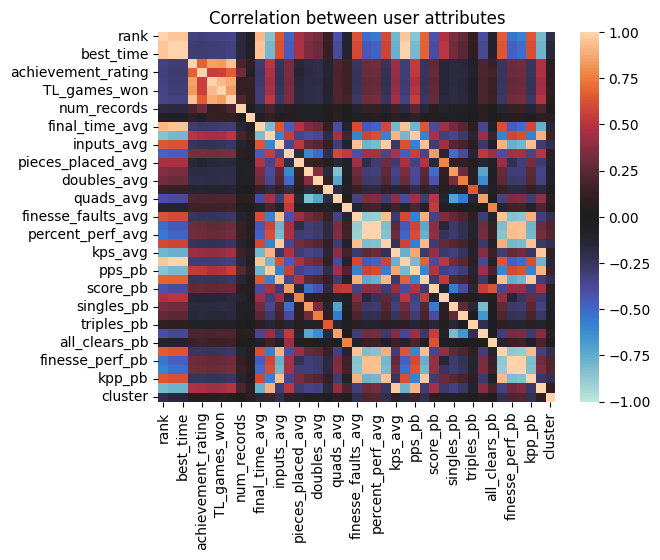

In [ ]:
# seaborn.heatmap(user_df.corr(numeric_only=True), cmap="icefire", center=0, vmin=-1, vmax=1).set(title="Correlation between user attributes")

In [19]:
corr = user_df.corr(numeric_only=True)

In [20]:
cluster = alt.Chart(corr.drop("cluster", axis=0).reset_index(), title="Cluster").mark_rect().encode(
    x='index',
    tooltip='cluster',
    color=alt.Color('cluster').scale(scheme='redblue')
).interactive()

best = alt.Chart(corr.drop("best_time", axis=0).reset_index(), title="Best Time").mark_rect().encode(
    x='index',
    tooltip='cluster',
    color=alt.Color('best_time').scale(scheme='redblue')
).interactive()

cluster# & best

alt.Chart(...)

In [26]:
alt.Chart(user_df.sample(1000)).mark_circle().encode(
    x="cluster",
    y="final_time_avg",
    color=alt.Color("cluster").scale(scheme="turbo"),
    tooltip=["username", "cohort", "cluster"]
).interactive()

alt.Chart(...)

In [34]:
cluster_avgs = user_df.select_dtypes(include=np.number).groupby('cluster').mean().reset_index()
cluster_avgs.head()

,cluster,rank,cohort,best_time,xp,achievement_rating,TL_games_played,TL_games_won,TL_play_time,num_records,...,singles_pb,doubles_pb,triples_pb,quads_pb,all_clears_pb,finesse_faults_pb,finesse_perf_pb,percent_perf_pb,kpp_pb,kps_pb
0,0,156365.632176,78.807615,79307.070051,2.149691e+06,18.460022,2116.811198,915.357969,600497.393963,17.663158,...,13.619037,5.140948,1.661889,2.718328,0.028070,86.196790,62.014259,0.594875,4.020472,0.005484
1,1,525074.239230,134.279849,134777.997736,1.146235e+05,0.532583,131.326948,45.660817,41161.305133,9.765073,...,21.071180,5.990979,1.154700,0.891156,0.000441,178.831614,36.564830,0.348325,4.961701,0.003924
2,2,878731.190696,210.892961,211390.007821,4.236994e+04,0.486003,52.023706,14.017516,16426.467830,4.930138,...,21.817476,6.264563,0.989563,0.714320,0.006513,355.700000,16.541303,0.152031,6.739680,0.003531
3,3,52612.369249,52.554479,53058.397902,2.653943e+06,58.577482,751.722760,335.547215,847478.807712,1445.138015,...,10.325666,3.944310,1.272397,4.424939,0.050847,46.489104,75.704600,0.739699,3.404413,0.007317
4,4,205681.543050,84.243388,84733.513881,6.745659e+05,13.270962,517.139842,229.519977,205828.288962,16.846652,...,6.718627,2.487901,0.597355,2.700900,0.786719,48.350310,83.868036,0.770321,3.985755,0.005909


In [38]:
alt.Chart(cluster_avgs).mark_circle().encode(
    x="cluster",
    y="triples_pb",
    color=alt.Color("rank").scale(scheme="turbo"),
    tooltip=["cluster"]
).interactive()

alt.Chart(...)